# Домашнее задание №3
Домашнее задание включает в себя следующие пункты:
1. Написать собственную свертку
2. Написать модуль батч нормализации для картинок
3. Написать модули для оптимизации SGD+momentum, Adam
4. Построить графики и обучения и сделать выводы по сравнению обучения, c различными гиперпараметрами (коэффициент обучения и betas)
    * SGD, SGD+momentum, Adam
    
За все три задания 1 бал, срок выполнения 2 недели, после 0.5 бала.

# 1. Реализация собственной свертки
В этом пункте Вам нужно реализовать модуль необучаемой свертки 2D. Используем только библиотеку pytorch. Получаем на вход тензор размером $(B, C_{in}, H, W)$, на выходе получаем тензор $(B, C_{out}, H_{out}, W_{out})$.
$$
B \ - \ размерность\ батча. \\
H - высота. \\
W - ширина. \\
С - количество\ каналов \\
$$
Реализуем операцию свертки:
$$
\begin{equation*}
\text{out}(B_i, C_{out_j}) = \text{bias}(C_{out_j}) +
                        \sum_{k = 0}^{C_{in} - 1} \text{kernel}(C_{out_j}, k) \star \text{x}(B_i, k)
\end{equation*},
$$

где $\large k $ - ядро свертки, с парамерами $C_{in}, H_k, W_k, stride_{H,W}, padding_{H,W}  $.

Формулы расчета размера выходной картинки
$$
\begin{align}\begin{aligned}H_{out} = \left\lfloor\frac{H_{in}  + 2 \times \text{padding}_H- \text{kernel_size}_H}{\text{stride}_H} + 1\right\rfloor\\W_{out} = \left\lfloor\frac{W_{in}  + 2 \times \text{padding}_W - \text{kernel_size}_W}{\text{stride}_W} + 1\right\rfloor\end{aligned}\end{align}
$$
Графическое представление 2D свертки
### Представление свертки
Параметры: kernel=3x3, padding=0,0
<img src="./imgs/18.jpg">

### Stride
Параметры: kernel=2x2, padding=0,0, stride=2,2
<img src="./imgs/22.gif" width=300>

### Padding
Параметры: kernel=2x2, padding=1,1, stride=1,1
<img src="./imgs/23.gif" width=400>



### Для проверки работоспособности сверки можно использовать 

```python 
from torch.nn.functional import conv2d
```
### Добавление дополнительной размерности в тензор
B - размер батча в нашем случае 1, размер картинки $C\times H \times W$. Для добавления и схлопывания размерностей используем
  - squeeze() - убирает размерность
  - unsqueeze() - добавляет размерность

In [1]:
import torch

In [2]:
t = torch.ones((4,4,4,5))

In [3]:
#Давайте реализуем применение паддинга к тензору(расширение)

def tensor_extend(our_input, padding):
    
    padding_w = padding[0]
    padding_h = padding[1]
    #делаем такой порядок, так как почему то в тензоре по условию сначала идет высота, а потом ширина.
    B = our_input.shape[0]
    C = our_input.shape[1]
    H = our_input.shape[2]
    W = our_input.shape[3]
    
    output = torch.zeros((B, C, H + 2 * padding_h, W + 2 * padding_w ))
    
    for tensor in range(B):
        for color in range(C):
            for y in range(H):
                for x in range(W):
                    output[tensor, color, y + padding_h, x + padding_w] = our_input[tensor, color, y, x]
    return output
                    
                    
# res = tensor_extend(t, [1,1])
# res.shape

In [4]:
#Также отдельно сделаем функцию, которая считает размер выхода после свертки и задает ее

def after_conv2d(our_input, kernel, padding, stride):
    import math
    B = our_input.shape[0]
    C = our_input.shape[1]
    H = our_input.shape[2]
    W = our_input.shape[3]
    
    kernel_w = kernel.shape[1]
    kernel_h = kernel.shape[2]
    
    padding_w = padding[0]
    padding_h = padding[1]
    
    stride_w = stride[0]
    stride_h = stride[1]
    
    B_output = B
    C_output = C
    
    H_output = math.floor((H + 2*padding_h - kernel_h)/stride_h + 1)
    W_output = math.floor((H + 2*padding_w - kernel_w)/stride_w + 1)
    
    res = torch.zeros((B_output, C_output, H_output, W_output))
    return res


In [5]:
#Теперь реализуем функцию, которое будет вычислять значение клеточек в конечном тензоре
def mult_add(our_input, kernel):
        #print("input part size", our_input.shape)
        #print("kernel zise", kernel.shape)
        new_value = 0
        
        new_cell = our_input * kernel
        res = torch.sum(new_cell)
        new_value += res 
            
        return new_value

In [6]:
import numpy as np
a = torch.ones((1,2,3,4))
a = a.unsqueeze(0)
print(a.shape)
a = a.squeeze(0)
print(a.shape)

torch.Size([1, 1, 2, 3, 4])
torch.Size([1, 2, 3, 4])


In [7]:
def my_conv2d(x,
              kernel,
              stride=(1,1), padding=(0,0), bias=None):
    
    x = x.unsqueeze(0)
    
    B = x.shape[0]
    C = x.shape[1]
    H = x.shape[2]
    W = x.shape[3]
    
    extended = tensor_extend(x, padding)
    
    output = after_conv2d(x, kernel, padding, stride)
    
    for tensor in range(B):
        for color in range(C):
            for x in range(output.shape[3]):
                for y in range(output.shape[2]):
                    part_prepare = extended[tensor]
                    part = part_prepare[:, y*stride[1] + padding[1]: y*stride[1] + padding[1]+ kernel.shape[1], 
                                    x*stride[0] + padding[0]: x*stride[0] + padding[0] + kernel.shape[2]]
                    output[tensor, color, y, x] = mult_add(part, kernel)
    
    return output.squeeze(0)

## Тестируем функцию свертки

### Загружаем картинку 

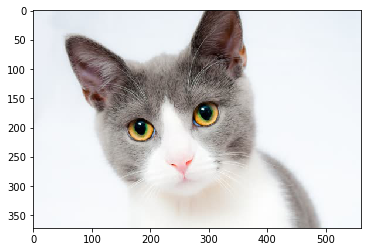

In [8]:
import torch
import torchvision as tv

# библиотека для отрисовки графиков, картинок .... 
import matplotlib.pyplot as plt
%matplotlib inline

# загрузка изображений
from PIL import Image
cat_convolve= Image.open('./imgs/cat_convolve.jpg')
plt.imshow(cat_convolve)

### Превращаем кота в тензор

In [9]:
cat_tensor = tv.transforms.ToTensor()(cat_convolve)
print (cat_tensor.size())

torch.Size([3, 372, 560])


### Сворачиваем картинку ядром, детектор границ
$$
\begin{bmatrix}
    -1       & -1 & -1  \\
    -1       & 8 & -1 \\
    -1       & -1 & -1
\end{bmatrix}
$$

### Создаем фильтр ядра и заполняем его -1 & 8

In [10]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(-1)
filter_kernel[:,1,1] = 8
print(filter_kernel.size())

torch.Size([3, 3, 3])


### Делаем свертку картинки ядром

torch.Size([3, 370, 370])


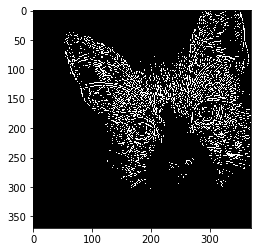

In [11]:
o_image = my_conv2d(cat_tensor, filter_kernel)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
print(o_image.size())
plt.imshow(o_image[0].numpy(), cmap='gray')

### Горизонтальные границы
$$
\begin{bmatrix}
    1       & 1 & 1  \\
    0       & 0 & 0 \\
    -1       & -1 & -1
\end{bmatrix}
$$

In [12]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(1)
filter_kernel[:,1,:] = 0
filter_kernel[:,2,:] = -1
print(filter_kernel.size())

torch.Size([3, 3, 3])


torch.Size([3, 370, 370])


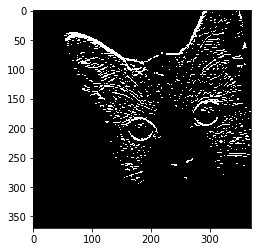

In [13]:
o_image = my_conv2d(cat_tensor, filter_kernel)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
print(o_image.size())
plt.imshow(o_image[0].numpy(), cmap='gray')

### Вертикальные границы
$$
\begin{bmatrix}
    1       & 0 & -1  \\
    1       & 0 & -1 \\
    1       & 0 & -1
\end{bmatrix}
$$

In [14]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(1)
filter_kernel[:,:,1] = 0
filter_kernel[:,:,2] = -1
print(filter_kernel.size())

torch.Size([3, 3, 3])


torch.Size([3, 370, 370])


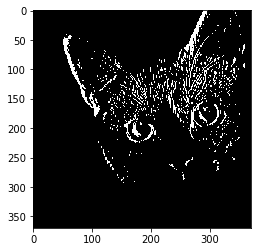

In [15]:
o_image = my_conv2d(cat_tensor, filter_kernel)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
print(o_image.size())
plt.imshow(o_image[0].numpy(), cmap='gray')

### Используем ядро 

$$ \begin{bmatrix}
    1 & 1 \\
    1 & 1
\end{bmatrix}$$

### и stride 2

torch.Size([3, 186, 186])


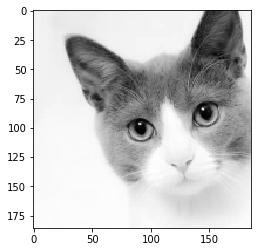

In [16]:
filter_kernelx2 = torch.FloatTensor(3,2,2).fill_(1)
o_image = my_conv2d(cat_tensor, filter_kernelx2, stride=(2,2))
o_image /= 4 # усредняем
print(o_image.size())
plt.imshow(o_image[0].numpy(), cmap='gray')

### Ядро свертки с гаусовым распределением

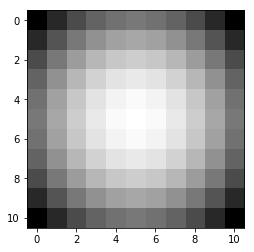

In [17]:
import scipy.ndimage as ndi
import numpy as np
sigma = 10    # параметр распределение
patern_size = 101 # максимальный размер ядра свертки
kernel_size = 10  # реальный размер свертки
x = np.zeros((patern_size, patern_size))
x [patern_size//2,patern_size//2]= 1

# делаем ядро с гаусовым распределением
gause_kernel = ndi.filters.gaussian_filter(x, sigma=sigma)
# вырезаем из центра наш кернел
gause_kernel = gause_kernel[(patern_size//2-(kernel_size//2)):(patern_size//2+(kernel_size//2))+1, \
                (patern_size//2-(kernel_size//2)):(patern_size//2+(kernel_size//2))+1]
# вот он
plt.imshow(gause_kernel, interpolation='none', cmap=plt.get_cmap('gray'))

# Делаем сверку 

torch.Size([3, 362, 362])


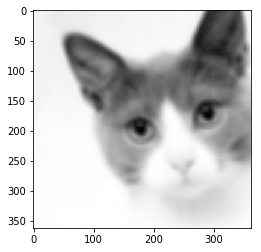

In [18]:
o_image = my_conv2d(cat_tensor, torch.from_numpy(gause_kernel).float().unsqueeze(0))
print(o_image.size())
plt.imshow(o_image[0].numpy(), cmap='gray')

# 2. Написать модуль батч нормализации для картинок
<img src="./imgs/37.png" width=400>

- Как выглядит формула финальной батч нормализации в слое при прямом проходе в процессе тренеровки сети, используем формулу для экспоненциального скользящего среднего:
$$
\large
\begin{align}
v_t = \beta \times v_{t-1} + (1-\beta)\times \mu_t \leftarrow для \ каждой \ ФИЧИ \ в \ батче \ расчитываем \ ее \ среднее \\ 
s_t = \beta \times s_{t-1} + (1-\beta)\times \sigma^2_t \leftarrow для \ каждой \ ФИЧИ \ в \ батче \ расчитываем \ ее \ дисперсию \\ \\
\hat{\mathbf{x}} = \frac{\mathbf{x_t} - v_t}{ \sqrt{s_t + \epsilon}} \times \gamma + b \leftarrow финальная \ формула \ для \ расчета  \ выхода\ слоя
\end{align}
$$

где $ \large \gamma, b $ - параметры, афинного преобразования, размерность - количество фичей во входном тензоре, эти параметры обучаются вместе с батч нормализацией

- Как выглядит правило для расчета выхода в процессе инференса:
$$
\large
\begin{align}
\hat{\mathbf{x}} = \frac{\mathbf{x_t} - v_t}{ \sqrt{s_t + \epsilon}} \times \gamma + b \leftarrow финальная \ формула \ для \ расчета  \ выхода\ слоя
\end{align}
$$

$\large s_t, v_t, \gamma, b $ - параметры расчитанные в процессе тренировки слоя.

### Задание:
Реализовать модуль 2d батч нормализации и проверить его работу на входных изображениях.

P.S. Каждый канал входной картинки считается отдельной фичёй

Нужные функции
```python
import torch
torch.zeros #- создать тензор заполненный нулями
torch.ones #- создать тензор заполненный единицами
torch.Tensor #- создать тензор(1, in_channels, 1, 1)
torch.mean, torch.var  #- среднее и дисперсия
x.uniform_ #- заполнить тензор случайными числами из равномерного распределения
y.expand_as(x) #- разширить тензор y до размера x, по расширяемым направлениям размерность тензора x должна быть равна 1 
```

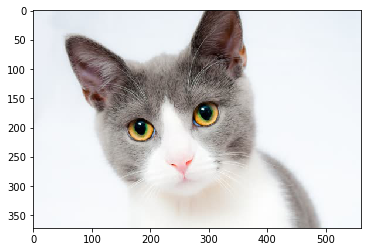

In [19]:
# b = torch.Tensor((4,4,4,4))
import torch
import torchvision as tv

# библиотека для отрисовки графиков, картинок .... 
import matplotlib.pyplot as plt
%matplotlib inline

# загрузка изображений
from PIL import Image
cat_convolve= Image.open('./imgs/cat_convolve.jpg')
plt.imshow(cat_convolve)

In [21]:
import torch.nn as nn

class BatchNorm2d(nn.Module):
    
    def __init__(self, in_channels, afine=True, beta=0.9, epsilon=1e-8):
        """
        :param in_channels: количество входных каналов предыдущего слоя
        :param afine: делать ли афинное преобразование.
        :param beta: параметр сглаживания
        :param epsilon: параметр исключающий деление на ноль
        """
        super().__init__()
        
        self.train = True
        
        self.afine = afine
        self.beta = beta
        self.in_channels = in_channels
        self.epsilon = epsilon
        
        self.V = torch.zeros(in_channels)
        self.S = torch.ones(in_channels)
        
        #gamma и b тоже сделаем атрибутами класса
        self.gamma = torch.Tensor(self.in_channels).uniform_()
        self.b = torch.Tensor(self.in_channels).uniform_()
        
        
    def forward(self, x):
        """
        Считаем параметры нормализации в режиме обучения, и нормализуем x в обоих режимах
        """
        #B, C, W, H = x.shape
        #Зададим тензоры с равномерным распределением
        gamma = torch.Tensor(self.in_channels).uniform_()
        b = torch.Tensor(self.in_channels).uniform_()
       # X = torch.Tensor(x.shape)
        X = x
        if self.train:
            #обучение
            for i in range(self.in_channels):
                
                mean = torch.mean(X[:, i])
                var = torch.var(X[:, i])

                self.V[i] = self.beta*self.V[i]+(1-self.beta)*mean
                self.S[i] = self.beta*self.S[i]+(1-self.beta)*var*var
            #Занесем в атрибуты
            self.running_mean = torch.mean(self.V)
            self.running_var = torch.mean(self.S)
                
        #проход     
        for i in range(self.in_channels):
            X[:,i] = (X[:, i]- self.V[i])/(self.epsilon+ self.S[i])**(0.5)
            
        if self.afine:
            for i in range(self.in_channels):
                X[:, i, :, :] = X[:, i, :, :] * self.gamma[i] + self.b[i]
        return X

### Проверяем работу батч нормадлизации на котэ

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 372, 560])


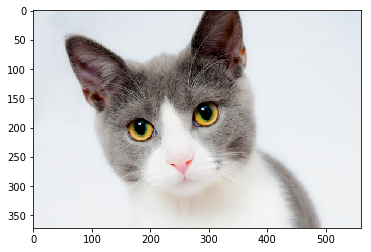

In [22]:
# Без афинных преобразований, за один проход не должно быть значительных изменений, потому что начальные значеня среднего 0 
# и дисперсии 1 
bn = BatchNorm2d(3, afine=False)
# добавляем размерность батча
o_image = bn(cat_tensor.unsqueeze(0))
# убираем размерность батча
o_image = o_image.squeeze()
print (o_image.size())
# для вывода картинки транспонируем тензор и превращаем его в numpy
plt.imshow(o_image.transpose(0,2).transpose(0,1).numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 372, 560])


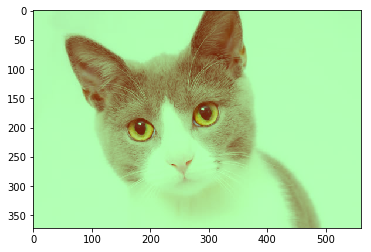

In [23]:
# C афинными преобразованиями, должен нагладыватья uniform_ шум при каждом новом запуске
bn = BatchNorm2d(3, afine=True)
# добавляем размерность батча
o_image = bn(cat_tensor.unsqueeze(0))
# убираем размерность батча
o_image = o_image.squeeze()
print (o_image.size())
# для вывода картинки транспонируем тензор и превращаем его в numpy
plt.imshow(o_image.transpose(0,2).transpose(0,1).numpy())

### Проверим как реализация работает на большом сете картинок

In [24]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [26]:
# Загружаем MNIST
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home='./')
X = mnist['data']
# переходим к формату тензоров pytorch
X = X.reshape((-1, 1, 28, 28))
X = X.astype('float')
print(X.shape)

(70000, 1, 28, 28)


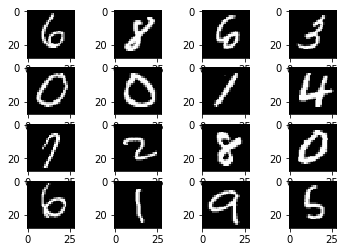

In [27]:
n=4
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = X[np.random.randint(0, X.shape[0]),0]
    plt.imshow(I, cmap='gray')

### Тестируем модуль батч нормализации на мнисте
Прогоняем весь поток картинок (1 эпоха) с размером батча 32, и смотрим как расчитываются средние значения в процессе тренировки

In [28]:
# функция тестирования BN
def test_batch_norm(bn):
    bn.train = True
    # количество эпох и размер батча
    c_epoch = 1
    batch_size = 32
    # данные для отчета
    mean_curve = []
    var_curve = []
    for iter in range(c_epoch):
        Xperm = np.random.permutation(X.shape[0])
        loss_acc = 0
        nbatches = X.shape[0]//batch_size
        for b in range(nbatches):
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = torch.Tensor(X[batch_idxs])
            bn(x)
            mean_curve +=  [ bn.V[0].double() ]
            var_curve +=  [ bn.S[0].double() ]
    return mean_curve, var_curve

In [29]:
# параметры beta = 0.9, 0.99, 0.5
bn_09 = BatchNorm2d(1, beta=0.9)
bn_099 = BatchNorm2d(1, beta=0.99)
bn_05 = BatchNorm2d(1, beta=0.5)
# ставим обучение в True
bn.train = True
# количество эпох и размер батча
c_epoch = 1
batch_size = 32
# данные для отчета
mean_curve_09, var_curve_09 = test_batch_norm(bn_09)
mean_curve_099, var_curve_099 = test_batch_norm(bn_099)
mean_curve_05, var_curve_05 = test_batch_norm(bn_05)

Смотрим какие значения средних и дисперсий у нас получились

In [ ]:
plt.figure(figsize=(20,20))
ax = plt.subplot(2,2,1)
ax.plot(mean_curve_09,label="mean_09")
ax.plot(mean_curve_099,label="mean_099")
ax.legend()
ax = plt.subplot(2,2,2)
ax.plot(mean_curve_05,label="mean_05",  color='g')
ax.legend()
ax = plt.subplot(2,2,3)
ax.plot(var_curve_09,label="var_09",)
ax.plot(var_curve_099,label="var_099",)
ax.legend()
ax = plt.subplot(2,2,4)
ax.plot(var_curve_05,label="var_05",  color='g')
ax.legend()


Посмотрим как повлияла батч нормализация на изображения

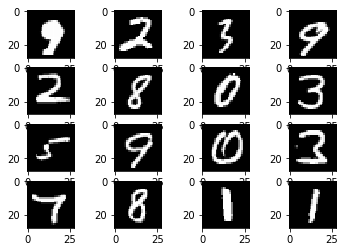

In [31]:
n=4
bn = bn_09
bn.train = False
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = X[np.random.randint(0, X.shape[0]),0]
    x = torch.Tensor(I)
    I = bn(x.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze()
    plt.imshow(I, cmap='gray')

## Done

# Реализуем свой Adam и SGD c моментом

Для реализации своего алгоритма оптимизации в pytorch нужно отнаслеловаться от базового класса Optimizer. При начальной инициализации алгоритма оптимизации он получает в качестве параматра все веса сети. Веса сети можно молучить через 
net.parameters(). По весам сети расчитывается градиент в функции loss.backward(). Веса сети организуются в группы, 
каждая группа образует словарь с сохраненными параметрами обучения, задаются в конструкторе, и самими параметрами, которые доступны по ключу "params". Параметры сети описываются классом Parameters. Для доступа к градиентам используется свойство grad.
Это тензор. Для сохранения параметров оптимизатор имеет свойство state, которое является словарем. Используется для
хранения промежуточных значений средних, дисперсий между шагами итераций.

**Задача** - реализовать функци step() для SGD и Adam, сравнить кривые обучения в зависимости от гиперпараметров (коэффициент обучения, betas), сделать выводы


## Adam (Adaptive Moment Estimation) 

Adam = SGD + Momentum + RMSProp

$$
\large
\begin{align}
m_t &= \alpha \times \ m_{t-1} + (1 - \alpha)\times g - момент \\ 
v_t &= \beta \times v_{t-1} +  (1-\beta)\times g_{t}^2  - скользящее\ среднее \ по \ квадрату \ градиента \\
\\
\hat{m_t} &= \frac{m_t}{1 - \alpha^t}\\
\hat{v_t} &= \frac{v_t}{1 - \beta^t}\\
\theta_t &= \theta_{t-1} -  \frac{\lambda}{\sqrt{\hat{v_t} + \epsilon}}\times \hat{m_t} \\
\ выразим\ step\_size \ через \ \alpha \ и \ \beta \\
\ step\_size =  \lambda \frac {({1 - \beta^t})^2}{{1 - \alpha^t}} \\ 
\theta_t &= \theta_{t-1} -  \frac{step\_size}{\sqrt{v_t + \epsilon}}\times m_t 
\end{align}
$$

Полезные функции

```python
import torch
torch.zeros_like(x)  # сделать тензор нулей такойже как x
tensor.addcmul_, addcdiv_, mul_  # все функции операции с тензорами, которые заканчиваются на _ присваивают результат в self тензор 
```


In [50]:
from torch.optim import Optimizer
import math

class Adam(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8):
        """
        :param params: - параметры оптимизируемой сети
        :param betas: - коэффициенты сглаживания
        :param eps: - 
        """
        defaults = dict(lr=lr, betas=betas, eps=eps)
        # тут вызываем конструктор базового класса и сохраняем параметры обучения
        # их можно достать через self.param_groups
        super(Adam, self).__init__(params, defaults)
        #вводим
        self.lr = lr
        self.betas = betas
        self.eps = eps

    def step(self):
        """
        Выполняем оптимизационный шаг
        """
        loss = None

        for group in self.param_groups:
            # итерируемся по всем группам параметров нашей сети
            # тут можно вытащить сохраненные параметры в группе
            beta1, beta2 = group['betas'] # betas
            eps = group['eps'] # эпсилон
            lr = group['lr'] # коэффициент обучения
            
            for param in group['params']:
                # итерируемся по всем парамерам в данно группе
                # если нет градиента по параметрам скипаем его
                if param.grad is None:
                    continue
                    
                # забираем тензор градиента    
                grad = param.grad.data
                # сами параметры для обновления лежат тут
                # p.data
                
                # тут храняться значения, которые мы расчитываем в процессе 
                # по каждому параметру в группе нужно расчитывать свои значения
                state = self.state[param]

                # если параметры мы еще не записали инициализируем их значения
                if len(state) == 0:
                    state['step'] = 0
                    # скользящее среднее по градинтам
                    state['avg'] = torch.zeros_like(grad) # нужно проинициализировать TODO
                    # скользящее среднее по квадрату градиентов
                    state['avg_sq'] = torch.zeros_like(grad)  # нужно проинициализировать TODO

                # тут можем достать сохраненные состояния
                exp_avg, exp_avg_sq = state['avg'], state['avg_sq']
                        
                # запоминаем шаг 
                state['step'] += 1
                
             
                

                # Считаем параметры. Записывать обратно в state не нужно, ибо мы получаем ссылку
                # TODO
                
                state['avg'] = beta1*state['avg']+(1-beta1)*grad
                state['ang_sq'] = beta2*state['avg_sq']+(1-beta2)*grad*grad
                

                # обновляем веса в p.data, 
                # TODO
                
                step_size = self.lr * ((1-beta2**state['step'])**2 / (1-beta1**state['step']))
                param.data -= step_size / (self.eps + state['avg_sq'])**(0.5) * state['avg']


        return loss

## SGD + Momentum
$$
\Large
\begin{align}
g_t &= \nabla_{\theta} \overset{\wedge}{\large J}\left(x,y,\theta \right) - градиент \\
m_t &= \beta \times m_{t-1} - (1- \beta) \times g_t, \ где \  \beta - параметр\ обучения \\
m_t &= \alpha \times m_{t-1} - \lambda \times g_t, \ альтернативная \ форма \ записи \\
\theta_t &= \theta_{t-1} + m_t
\end{align}
$$

In [33]:

class SGD(Optimizer):
    def __init__(self, params, lr, beta=0.9):
        """
        :param params: - параметры оптимизируемой сети
        :param beta: - коэффициент сглаживания, если 0, получаем обычный SGD
        :param eps: - 
        """        
        defaults = dict(lr=lr, beta=beta)
        # тут вызываем конструктор базового класса и сохраняем параметры обучения
        # их можно достать через self.param_groups 
        super(SGD, self).__init__(params, defaults)
        self.lr = lr
        self.beta = beta

    def step(self):
        """
        Выполняем оптимизационный шаг
        """

        loss = None

        for group in self.param_groups:
            # итерируемся по всем группам параметров нашей сети
            # тут можно вытащить сохраненные параметры в группе            
            beta = group['beta']
            lr = group['lr']
            for param in group['params']:
                if param.grad is None:
                    continue
                # gradient                                
                grad = param.grad.data
                
                
                if beta != 0:
                    # тут добавляем момент если он указан
                    # todo
                    moment = torch.zeros_like(grad)
                    moment = beta*moment-(1-beta)*grad
                    param.data += self.lr * moment
                    

                # обновляем веса
                # to do
                param.data -= self.lr * grad

        return loss


Тут векторизуем наш выход как OneHotEncoder вектор. Если объект принадлежит классу значение 1 нет 0.

In [34]:
from sklearn.preprocessing import OneHotEncoder

Y = mnist['target'].astype('int')
print('original', Y)


original [0 0 0 ... 9 9 9]


In [35]:
USE_CUDA=False

## Определение нашей модели
Параметры инициализации
- Без параметров - конволюции и активации
- dropout = True - c dropout
- batchnorm = True - включаем  batch normalization

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    # Слои, в которых нет параметров для обучения можно не создавать, а брать из переменной F
    def __init__(self, dropout=False, batchnorm=False):
        super(Net, self).__init__()
        #
        # спецальный модуль, который позволяет 
        # объединять компоненты
        self.net = nn.Sequential(nn.BatchNorm2d(1))
        
        # вход 28x28, выход 24x24 (28-5)/1 + 1 = 24
        self.net.add_module('conv_1', nn.Conv2d(1, 8, kernel_size=5, stride=1))
        self.net.add_module('relu_1', nn.ReLU())  
        
        # добавляем дропаут и бн
        if batchnorm: self.net.add_module('bn_1', nn.BatchNorm2d(8))
        if dropout: self.net.add_module('do_1', nn.Dropout(0.5))
            

        
        # конволюция, которая уменьшает размер картинки в два раза 
        # (24-2)/2+1 = 12, либо используем nn.MaxPool2d
        self.net.add_module('pool_1', nn.Conv2d(8, 8, kernel_size=2, stride=2)) 
        
        # далее conv->relu->pool
        self.net.add_module('conv_2', nn.Conv2d(8, 16, 5)) # in 12x12, out 8x8
        self.net.add_module('relu_2', nn.ReLU() ) 
        
        # добавляем дропаут и бн
        if batchnorm: self.net.add_module('bn_2', nn.BatchNorm2d(16))
        if dropout: self.net.add_module('do_2', nn.Dropout(0.5))
            

        self.net.add_module('pool_2', nn.MaxPool2d(kernel_size=2, stride=2))                  
        self.fc1 = nn.Linear(16 * 4 * 4, 10)
        # relu

    def forward(self, x):
        x = self.net(x)
        # Вытягиваем многомерный тензор катринки в одну линию
        x = x.view(-1, 16 * 4 * 4)
        x = self.fc1(x)
        x = F.relu(x)
        return x

## Функция обучения модели

In [37]:
def fit_net(c_epoch, network, optimizer):
    loss_fn = torch.nn.CrossEntropyLoss()
    if USE_CUDA:
        loss_fn = loss_fn.cuda()

    batch_size = 32
    loss_curve = []

    for iter in range(c_epoch):
        Xperm = np.random.permutation(X.shape[0])
        loss_acc = 0
        nbatches = X.shape[0]//batch_size
        for b in range(nbatches):
            optimizer.zero_grad()  
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = torch.Tensor(X[batch_idxs])
            y = torch.from_numpy(Y[batch_idxs]).long()
            if USE_CUDA:
                x = x.cuda()
                y = y.cuda()
            y_pred = network(x)
            loss = loss_fn(y_pred, y)
            loss_acc += float( loss[0] )
            loss.backward() # <-- тут расчитывается градиент
            optimizer.step()  # <-- тут происходит обновление весов
        avg_epoch_loss = loss_acc / (nbatches)
        print('Do epoch %s with loss %s' % (iter, avg_epoch_loss ))
        loss_curve.append(avg_epoch_loss)
    
    return loss_curve

## SGD без момента

In [43]:
learning_rate = 1e-1 # 
net = Net(batchnorm=True) # инициализация сети
net = net.cuda() if USE_CUDA else net # если нужно тащим ее на GPU
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.0) # создаем оптимизатор с параметрами
loss_curve_sgd = fit_net(10, net, optimizer) # обучаем сеть

/home/agavrilenko/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.24841104899577807
Do epoch 1 with loss 0.054944644020772385
Do epoch 2 with loss 0.041583794829613226
Do epoch 3 with loss 0.03442121162554092
Do epoch 4 with loss 0.02934710563564606
Do epoch 5 with loss 0.025048344901532522
Do epoch 6 with loss 0.023193437308004907
Do epoch 7 with loss 0.020832944864080983
Do epoch 8 with loss 0.01782861138022431
Do epoch 9 with loss 0.017143029796243204


In [44]:
learning_rate = 1e-3 # 
net = Net(batchnorm=True) # инициализация сети
net = net.cuda() if USE_CUDA else net # если нужно тащим ее на GPU
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.0) # создаем оптимизатор с параметрами
loss_curve_sgd_1 = fit_net(10, net, optimizer) # обучаем сеть

/home/agavrilenko/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 1.1665430229359912
Do epoch 1 with loss 0.3523322793348063
Do epoch 2 with loss 0.22712227259602893
Do epoch 3 with loss 0.17971576727793867
Do epoch 4 with loss 0.15147950959821568
Do epoch 5 with loss 0.13280702544828502
Do epoch 6 with loss 0.11853340879307525
Do epoch 7 with loss 0.10747831464358863
Do epoch 8 with loss 0.0990922429420439
Do epoch 9 with loss 0.09205943522493644


## SGD с моментом

In [45]:
learning_rate = 1e-1
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.9)
loss_curve_sgd_momentum = fit_net(10, net, optimizer)

/home/agavrilenko/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.1261002710169998
Do epoch 1 with loss 0.04196510623048635
Do epoch 2 with loss 0.03450521003330577
Do epoch 3 with loss 0.029352434725591348
Do epoch 4 with loss 0.024652413076797358
Do epoch 5 with loss 0.02232688248402788
Do epoch 6 with loss 0.02050824377517151
Do epoch 7 with loss 0.018077870744872868
Do epoch 8 with loss 0.016413922298565052
Do epoch 9 with loss 0.016123011026907906


In [46]:
learning_rate = 1e-3
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.9)
loss_curve_sgd_momentum1 = fit_net(10, net, optimizer)

/home/agavrilenko/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.9413862558780983
Do epoch 1 with loss 0.2866201134450533
Do epoch 2 with loss 0.19165106670982934
Do epoch 3 with loss 0.14944310635873373
Do epoch 4 with loss 0.12443065058029455
Do epoch 5 with loss 0.10811177355666983
Do epoch 6 with loss 0.09641051045088775
Do epoch 7 with loss 0.0877160754652671
Do epoch 8 with loss 0.08124200844388603
Do epoch 9 with loss 0.07560188601591514


In [47]:
learning_rate = 1e-1
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.3)
loss_curve_sgd_momentum01 = fit_net(10, net, optimizer)

/home/agavrilenko/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.16732458958328178
Do epoch 1 with loss 0.04706701349294998
Do epoch 2 with loss 0.037526239665283914
Do epoch 3 with loss 0.031486695478182704
Do epoch 4 with loss 0.02845409968344109
Do epoch 5 with loss 0.024720996703439833
Do epoch 6 with loss 0.02270036092633573
Do epoch 7 with loss 0.020210764828641828
Do epoch 8 with loss 0.018804511221429777
Do epoch 9 with loss 0.01735594221375879


In [48]:
learning_rate = 1e-3
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.3)
loss_curve_sgd_momentum02 = fit_net(10, net, optimizer)

/home/agavrilenko/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.6151705062349856
Do epoch 1 with loss 0.18616703980498844
Do epoch 2 with loss 0.1313224883284207
Do epoch 3 with loss 0.10643793948788484
Do epoch 4 with loss 0.0915841849143504
Do epoch 5 with loss 0.08149088522616074
Do epoch 6 with loss 0.07316683017477141
Do epoch 7 with loss 0.06741524280602931
Do epoch 8 with loss 0.06271950837188951
Do epoch 9 with loss 0.05863623069637597


## Adam

In [51]:
learning_rate = 1e-1
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999))
loss_curve_adam0 = fit_net(10, net, optimizer)

/home/agavrilenko/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 2.2732475366993588
Do epoch 1 with loss 2.3025848865509033
Do epoch 2 with loss 2.3025848865509033
Do epoch 3 with loss 2.3025848865509033
Do epoch 4 with loss 2.3025848865509033
Do epoch 5 with loss 2.3025848865509033
Do epoch 6 with loss 2.3025848865509033
Do epoch 7 with loss 2.3025848865509033
Do epoch 8 with loss 2.3025848865509033
Do epoch 9 with loss 2.3025848865509033


In [52]:
learning_rate = 1e-3
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999))
loss_curve_adam1 = fit_net(10, net, optimizer)

/home/agavrilenko/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 1.8813620308966847
Do epoch 1 with loss 2.3025848865509033
Do epoch 2 with loss 2.3025848865509033
Do epoch 3 with loss 2.3025848865509033
Do epoch 4 with loss 2.3025848865509033
Do epoch 5 with loss 2.3025848865509033
Do epoch 6 with loss 2.3025848865509033
Do epoch 7 with loss 2.3025848865509033
Do epoch 8 with loss 2.3025848865509033
Do epoch 9 with loss 2.3025848865509033


In [67]:
learning_rate = 1e-4
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.7, 0.999))
loss_curve_adam2 = fit_net(10, net, optimizer)

/home/agavrilenko/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.26121233442179076
Do epoch 1 with loss 0.08092374116468495
Do epoch 2 with loss 0.07060360662881021
Do epoch 3 with loss 0.06592111395451376
Do epoch 4 with loss 0.058314013420499834
Do epoch 5 with loss 0.05570835422572885
Do epoch 6 with loss 0.04907415444768069
Do epoch 7 with loss 0.04975541148234242
Do epoch 8 with loss 0.04830014257328555
Do epoch 9 with loss 0.04517033192144718


In [66]:
learning_rate = 1e-5
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.8, 0.999))
loss_curve_adam3 = fit_net(10, net, optimizer)

/home/agavrilenko/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.4419889803285952
Do epoch 1 with loss 0.061098946863977016
Do epoch 2 with loss 0.04408380048537723
Do epoch 3 with loss 0.03645374581974066
Do epoch 4 with loss 0.030596856073832807
Do epoch 5 with loss 0.02711836906481291
Do epoch 6 with loss 0.023538529160881783
Do epoch 7 with loss 0.021718563247092194
Do epoch 8 with loss 0.01972581511921244
Do epoch 9 with loss 0.016869154394654088


# Кривые обучения

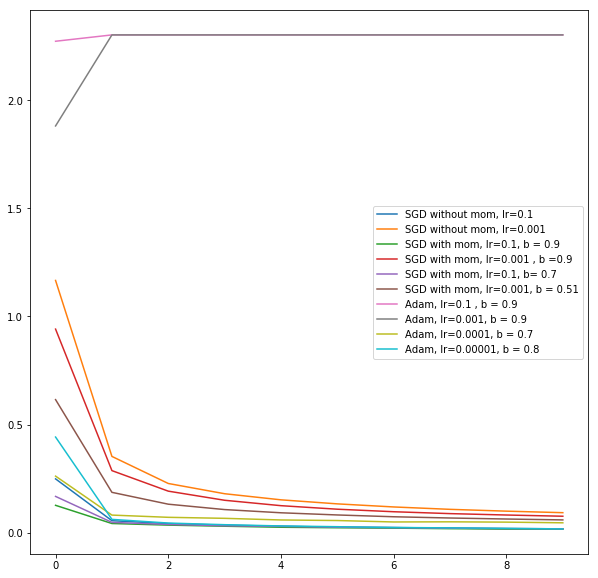

In [69]:
plt.figure(figsize=(10,10))
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_sgd, label="SGD without mom, lr=0.1")
ax.plot(loss_curve_sgd_1, label="SGD without mom, lr=0.001")
ax.plot(loss_curve_sgd_momentum, label="SGD with mom, lr=0.1, b = 0.9")
ax.plot(loss_curve_sgd_momentum1,label="SGD with mom, lr=0.001 , b =0.9")
ax.plot(loss_curve_sgd_momentum01, label="SGD with mom, lr=0.1, b= 0.7")
ax.plot(loss_curve_sgd_momentum02, label="SGD with mom, lr=0.001, b = 0.51")
ax.plot(loss_curve_adam0, label='Adam, lr=0.1 , b = 0.9' )
ax.plot(loss_curve_adam1, label='Adam, lr=0.001, b = 0.9' )
ax.plot(loss_curve_adam2, label='Adam, lr=0.0001, b = 0.7' )
ax.plot(loss_curve_adam3, label='Adam, lr=0.00001, b = 0.8' )

ax.legend()

### Выводы

_пишем выводы по сходимости и скорости обучения: Adam, SGD, SGD+momentum, с различными параметрами обучения lr и betas_

Извиняюсь за малое количество итераций - но комп просто не вывозит. 
1. Сходимость Adam - при lr cравнительно большом(0.1, 0.001) сходится довольно плохо(точнее вообще не сходится)- точно хуже SGD, но при их уменьшении на несколько порядков - сходится в разы лучше
2. SGD - без момента сходится быстрее тот, у которого меньше lr( очевидно, так как не прсокакивает минимум
3. SGD - с моментом схдится быстрее тот, у которого b меньше, также при большом lr и b сходится быстре чем Адам, также можно заметить, что в отличии от Адам( у которого изменение в практически не меняет сходимость) тут мы наблюдаем сильную кореляцию от момента. 